# Pairs Trade Algorithm
Brian Bahmanyar

***

The pairs trade is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. This strategy is categorized as a statistical arbitrage and convergence trading strategy. The pair trading was pioneered by Gerry Bamberger and later led by Nunzio Tartaglia’s quantitative group at Morgan Stanley in the 1980s.[1](https://en.wikipedia.org/wiki/Pairs_trade)

This notebook will introduce my implementation of pairs trade. We will be switching gears from the tech stocks to pairs of stocks I found to have similar overall trend.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

import sys
sys.path.append('./src/')
from random_walk_forcast import *

In [2]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})

In [3]:
pairs = pd.read_csv('data/pairs_bundle.csv', index_col=0)
pairs.index = pd.to_datetime(pairs.index)

In [4]:
def plot_pair(series1, series2, names):
    """
    Plot pair series with name subsitutions
    
    Args: series1 (ndarray)---first stock of the pair
          series2 (ndarray)---second stock of the pair
          names (list)--------list of names for the stocks
    Returns: (None) plots inline
    """
    
    fig, ax = plt.subplots(figsize=(20,8));
    years = YearLocator();
    yearsFmt = DateFormatter('%Y');
    
    ax.xaxis.set_major_locator(years);
    ax.xaxis.set_major_formatter(yearsFmt);
    ax.autoscale_view();
    
    index = series1.index
    
    plt.title(names[0] + ' and ' + 
              names[1] +' (Adj. Close)', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    ax.plot_date(index, series1, 'indianred', label=names[0]);
    ax.plot_date(index, series2, 'steelblue', label=names[1]);
 
    plt.legend(loc=2, prop={'size':15}, frameon=True);

Notice that the long term trends for these pairs of stocks (Verizon, At&t) and (Chrevron and Exxon) are very similar. We can assume that devations are due to random market fluxuations. With this assumption that the stock prices will converge eventually we can make a long term profit. 

The high level explanation of the algorithm, as I understand it, is when stocks move away from their long term trend sell shares of the stock thats increasing (being temporarily overvalued) and use those earnings to buy shares of the stock thats decreasing (being temporarily undervalued). This is called 'opening a position'. Then when the stocks converge, close your position, sell the stock you bought at a lower price and buy the stock you sold at a higher price. This assumes you own some shares of both these stocks throughout the process. 

The following algorithm will ignore keeping track of number of stocks at any given time. Meaning there may be situations where we sell stocks we don't own. This actually is not an issue because you can short stocks (instead of selling them) if you suspect the price will go down. Without getting into much of the finance I will move forward.

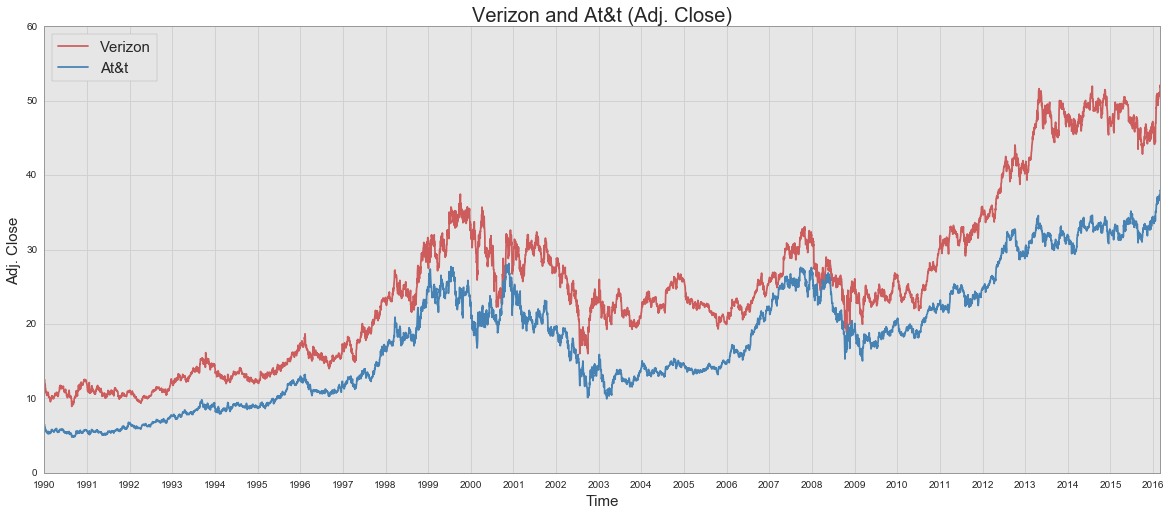

In [5]:
plot_pair(pairs['VZ'], pairs['T'], ['Verizon','At&t'])

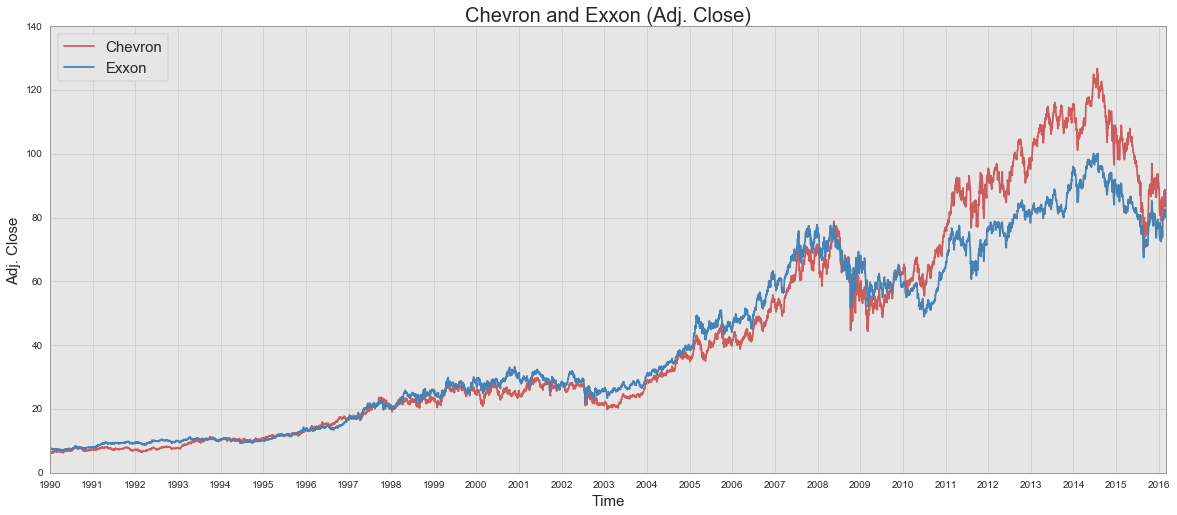

In [6]:
plot_pair(pairs['CVX'], pairs['XOM'], ['Chevron','Exxon'])

We will be working with the ratios of these pairs:

In [7]:
def plot_ratio(ratio, name, deviations=[1], positions=[]):
    """
    Plots the ratio of the stocks
    
    Args: ratio (ndarray)----the ratio of the stocks in question
          name (string)------the name of the ratio
          devations (list)---the devations to plot
          positions (list)---the positions to plot
    Returns: (None) plots inplace
    """
    fig = plt.subplots(figsize=(20,8));

    plt.title('Ratio ' + name + ' Adjusted Close', fontsize=20);
    plt.ylabel('Ratio', fontsize=15);
    plt.xlabel('Time Index', fontsize=15);
    plt.xlim([0,ratio.size])
    plt.xticks(np.arange(0, ratio.size, 500))
    
    plt.plot(np.arange(ratio.size), ratio, 'black', label='$Ratio$', alpha=0.5);
    plt.plot([0, ratio.size], [ratio.mean(), ratio.mean()], 'steelblue', lw=2, label=r'$\hat{\mu}$');
    
    for color, std in zip(['y','orange','salmon','red'], deviations):
        latex_prep = '$' + str(std) + '$'
        plt.plot([0, ratio.size], [ratio.mean()-std*ratio.std(), ratio.mean()-std*ratio.std()], 
                 '--', lw=2, label='$\hat{\mu} \pm$' + latex_prep + '$\hat{\sigma}$', color=color);
        plt.plot([0, ratio.size], [ratio.mean()+std*ratio.std(), ratio.mean()+std*ratio.std()], 
                 '--', lw=2, color=color);
    
    if positions:
        opening_days, closing_days = [], []
        opening_ratios, closing_ratios = [], []
        
        for position in positions:
            if 'open' in position.keys():
                for day in position['open']:
                    opening_days.append(day)
                    opening_ratios.append(ratio.ix[day])
            if 'close' in position.keys():
                closing_days.append(position['close'])
                closing_ratios.append(ratio.ix[position['close']])
            
        plt.scatter(x=opening_days, y=opening_ratios, s=125, color='lime', edgecolor='black', label='$Open$ '+'$Position$')
        plt.scatter(x=closing_days, y=closing_ratios, s=125, color='red', edgecolor='black', label='$Close$ '+'$Position$')
    
    plt.legend(loc='best', prop={'size':15}, frameon=True);

We see that for the Verizon/ATT ratio there is quite a lot of movement about their average ratio (about 1.5). 

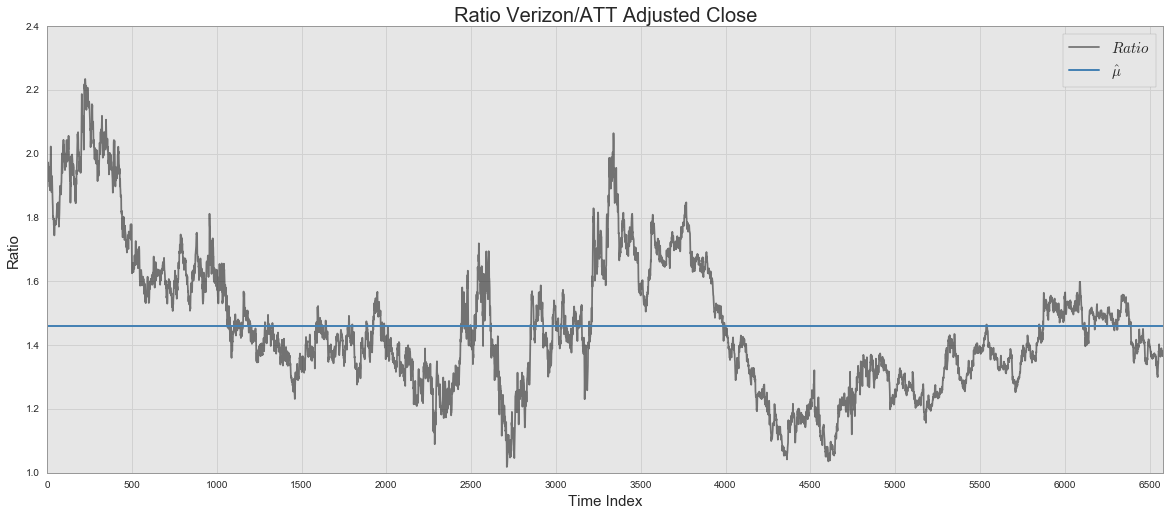

In [8]:
plot_ratio(pairs['VZ/T'], name='Verizon/ATT', deviations=[])

We see that for the Chevron/Exxon ratio there is a little bit of movement about their average ratio (about 1). 

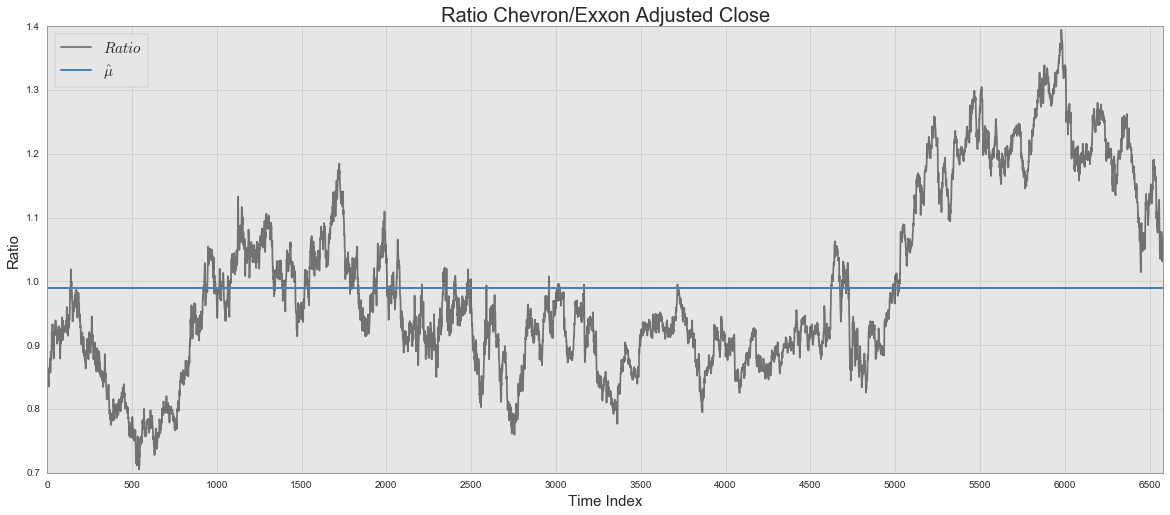

In [9]:
plot_ratio(pairs['CVX/XOM'], name='Chevron/Exxon', deviations=[])

In [10]:
def identify_positions(ratio, k, start=50):
    """
    Identifies all positions using a dynamic step value
    
    Args: ratio (ndarray)---the ratio of the stocks
          k (int)-----------the intial devation to open a position
          start (int)-------the day to start
    Results: (list of maps) the positions
    """
    results = []
    result = {"open":[]}
    mean, sd = ratio.mean(), ratio.std()
    day, size = start, ratio.size
    
    while day < size:   
        if abs(ratio.ix[day] - mean) > k*sd:
            result["open"].append(day)
            walk = get_expected_walk(ratio[:day], 20)[1]
            day += int(walk.max() / walk.min())
        elif abs(ratio.ix[day] - mean) < 0.05 and len(result["open"]) > 0 :
            result["close"] = day
            results.append(result)
            result = {"open":[]}
            day += 1
        else:
            day += 1
            
    if len(result['open']) > 0:
        result['close'] = day-1
        results.append(result)
        
    return results

Here we see the Verizon/At&t ratio plotted with an error line at 1 standard deviation. Where open positions are opened in green and closed in red.

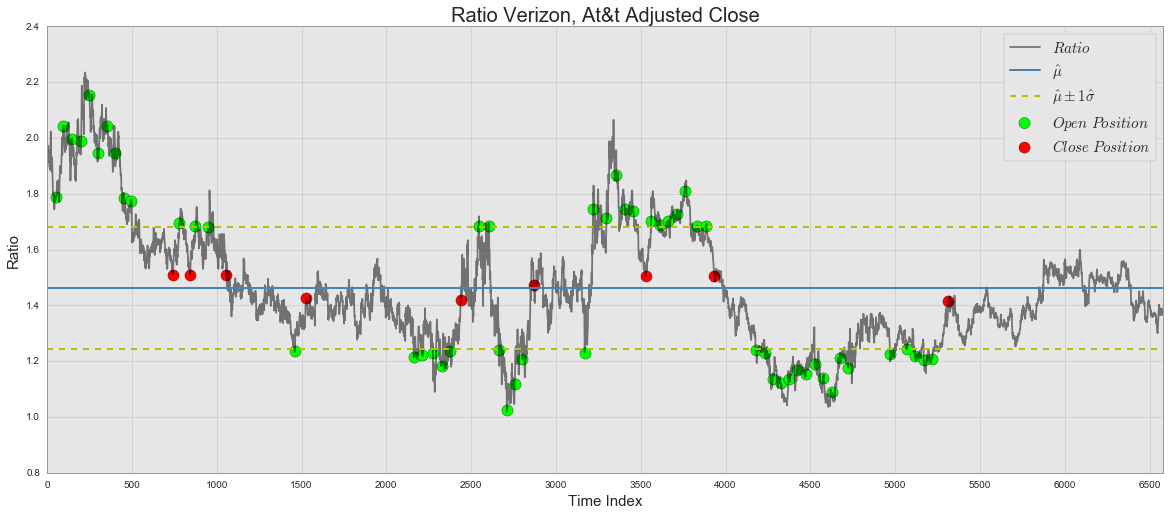

In [11]:
positions_cell = identify_positions(pairs['VZ/T'], 1)
plot_ratio(pairs['VZ/T'], 'Verizon, At&t', deviations=[1], positions=positions_cell)

Now it's time to back test out algorithm and calculate our return on investment if we had traded on it it for the past 25 years.

In [12]:
def back_trade(init_investment, numer_prices, denom_prices, ratio, positions, swap_count=50):

    """
    Back trades with the given positions
    
    Args: init_investment (int)----initial total investment
          numer_prices (ndarray)---the series of the numerator stock w/ respect to the ratio
          denom_prices (ndarry)----the series of the denominator stock w/ respect to the ratio
          ratio (ndarray)----------the ratio of the series'
          positions (list of maps)-the postions to trade on
          swap_count (int)---------the number of stocks to swap at a given open position
    Returns: (map) the result object
    """
    cur_portfolio_value = init_investment
    
    
    for position in positions:
        if all(ratio[position['open']] > ratio.mean()):
            openings = len(position['open'])
            cur_portfolio_value += np.sum(swap_count*numer_prices[position['open']])
            cur_portfolio_value -= np.sum(swap_count*denom_prices[position['open']])

            cur_portfolio_value -= openings*swap_count*numer_prices[position['close']]
            cur_portfolio_value += openings*swap_count*denom_prices[position['close']]
        elif all(ratio[position['open']] < ratio.mean()):
            openings = len(position['open'])
            cur_portfolio_value -= np.sum(swap_count*numer_prices[position['open']])
            cur_portfolio_value += np.sum(swap_count*denom_prices[position['open']])

            cur_portfolio_value += openings*swap_count*numer_prices[position['close']]
            cur_portfolio_value -= openings*swap_count*denom_prices[position['close']]
    
    return {'init_investment': init_investment,
            'net_gain': cur_portfolio_value - init_investment,
            'net_gain/year': (cur_portfolio_value - init_investment) / (len(ratio) / 252) } # 252 trade days / year

Using these positions we will back trade our algorithm. Using an initial investment of 10000 dollars and swaping 100 shares at each open position we net a total gain of about 15,500 dollars over about 25 years. Averaging out to about an 5% annual return on investment. This fails to beat the S&P500.

In [13]:
back_trade(10000, pairs['VZ'].values, pairs['T'].values, pairs['VZ/T'].values, positions_cell, 100)

{'init_investment': 10000,
 'net_gain': 15522.465675963802,
 'net_gain/year': 594.47740886669885}

Here we see the Chevron/Exxon ratio plotted with an error line at 1 standard deviation. Where open positions are opened in green and closed in red.

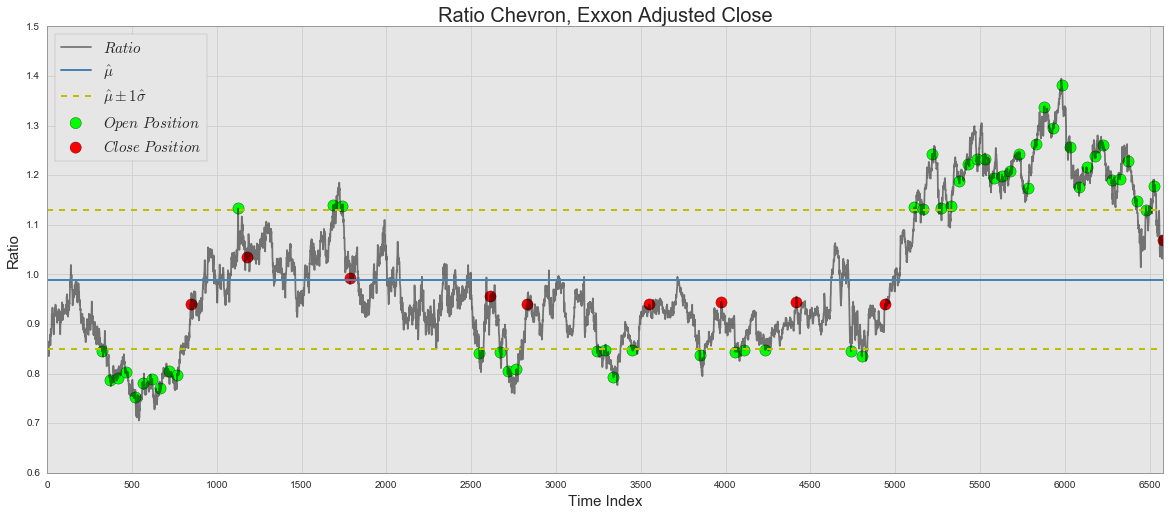

In [14]:
positions_gas = identify_positions(pairs['CVX/XOM'], 1)
plot_ratio(pairs['CVX/XOM'], 'Chevron, Exxon', deviations=[1], positions=positions_gas)

Using these positions we will back trade our algorithm. Using an initial investment of 10000 dollars and swaping 100 shares at each open position we net a total gain of about 40,000 dollars over about 25 years. Averaging out to about an 15% annual return on investment. This outpreforms the S&P. Of course we have to examine this method on many more stocks to tune our thresholds for oppening and closing positions.

In [15]:
back_trade(10000, pairs['CVX'].values, pairs['XOM'].values, pairs['CVX/XOM'].values, positions_gas, 100)

{'init_investment': 10000,
 'net_gain': 40231.343296289997,
 'net_gain/year': 1540.7748496451488}

___

In [16]:
from IPython.display import HTML
HTML("""<style>@import "http://fonts.googleapis.com/css?family=Lato|Source+Code+Pro|Montserrat:400,700";@font-face{font-family:"Computer Modern";src:url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf')}.rendered_html h1,h2,h3,h4,h5,h6,p{font-family:'Computer Modern'}p,ul{font-family:'Computer Modern'}div#notebook-container{-webkit-box-shadow:none;box-shadow:none}h1{font-size:70pt}h2{font-size:50pt}h3{font-size:40pt}h4{font-size:35pt}h5{font-size:30pt}h6{font-size:25pt}.rendered_html p{font-size:11pt;line-height:14pt}.CodeMirror pre{font-family:'Source Code Pro', monospace;font-size:09pt}div.input_area{border:none;background:#f5f5f5}ul{font-size:10.5pt;font-family:'Computer Modern'}ol{font-size:11pt;font-family:'Computer Modern'}.output_png img{display:block;margin-left:auto;margin-right:auto}</style>""")